# UNSUPERVISED LEARNING

## Simple example on Poission Equation. 


Objective: solve

$$
    \frac{d^2u(x)}{dx^2} = f(x)
$$

With boundary conditions $u(0) = u(1) = 0$. 

Let's pick a source term: $f(x) = \pi^2\sin(\pi x)$. This means that the equation has an exact solution and it is $u(x) = c_2x + c_1  -\sin(\pi x)$ By imposing the Dirichlet boundary conditions, we obtain that c_1 = c_2 = 0.

A Physics-Informed Neural Network is just a normal NN (e.g., MLP) trained to minimize a loss that enforces the physics — in this case, the Poisson equation.
We define a neural net $\hat{u}_{\theta}(x)$, and **instead of training it with labeled data, we train it by penalizing it when it violates the differential equation.**

To train a PINN, we need to define the loss function. The residual of the PINN is 

$$
    r(x) = \frac{d^2\hat{u}_{\theta}(x)}{dx^2} - f(x)
$$

Therefore, the component of the loss function would be: $\mathcal{L} = \mathcal{L}_{\text{Physics}} + \mathcal{L}_{\text{Boundary}}$

$$
    \mathcal{L}_{\text{Physics}} = \frac{1}{N}\sum^N_{i=1}(r(x^{(i)}))^2
$$

Since $\hat{u}_{\theta}(0) = \hat{u}_{\theta}(1) = 0$

$$
    \mathcal{L}_{\text{Boundary}} = (\hat{u}_{\theta}(0))^2 + (\hat{u}_{\theta}(1))^2
$$

Thus:

$$
    \mathcal{L} = \frac{1}{N}\sum^N_{i=1}(r(x^{(i)}))^2 + (\hat{u}_{\theta}(0))^2 + (\hat{u}_{\theta}(1))^2
$$



**FUNDAMENTAL CONCEPTS**: 
* AUTOMATIC DIFFERENTIATION (AD).
    * Forward and Reverse AD 
    * Reverse AD vs Backpropagation
* DIFFERENTIABLE PROGRAMMING
    * For instance: differentiable PIC code. Why even bother to make the PIC code differentiable if it's already fast? 
        * Once it’s differentiable:
            * Optimize initial conditions to reach desired states
            * Use gradient-based inverse modeling: “Given a final state, what beam velocity vb caused it?”
            * Couple it to a **neural network controller** or PDE and train both
            * Use it in physics-informed learning frameworks (like PINNs) with real data
        * This moves your simulation from static modeling into trainable, learnable physical systems.
    * IMPORTANT: differentiable programming is often used in training, not in production. 
    * IDA+ AD + Differentiable Programming + Gent PhD: [analysis with GPT](https://chatgpt.com/share/68765ab0-e934-8012-bc9e-e228e6edd69e)


In [1]:
# Example of forward and reverse automatic differentiation 

import jax
import jax.numpy as jnp

def f(x):
    return x**2 + jnp.sin(x)

# Derivative using forward mode
df_dx_fwd = jax.jacfwd(f)
# Derivative using reverse mode
df_dx_rev = jax.grad(f)

x = 2.0
print(df_dx_fwd(x))  # Forward-mode derivative
print(df_dx_rev(x))  # Reverse-mode derivative


3.5838532
3.5838532


**Overview of the Code**

1. Define the neural network `u_hat(x)` and optimizer

2. Compute the second derivative of `u_hat(x)` using `autograd`

3. Build the loss function (physics + boundary)

3. Train the model on collocation points

4. Compare with exact solution



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


# This is for plotting 
def exact_sol(x):
    return -np.sin(np.pi*x)

In [ ]:
# Define the Neural Network

class PINN(nn.Module): # creating a custom class (called PINN) that behaves like a PyTorch NN with all tools and methods that nn.Module offers.
    
    def __init__(self,layers): #  builds the network dynamically from a list called `layers`
        super(PINN,self).__init__() # Python inheritance magic
        self.net = nn.Sequential()
        for i in range(len(layers)-1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())                
    """
    Example of above __init__ function when layers = [1,20,20,1]. It creates:
        * Linear(1 → 20) → Tanh
        * Linear(20 → 20) → Tanh
        * Linear(20 → 1)
    Which means that the input to the NN is R^1 to output R^1. So it's a NN with two hidden layers. 
    """;
    
    def forward(self, x): # This is the key method that runs when you call your model: output = PINN(x)
        return self.net(x) 
    
    """
    Pytorch internally calls .forward() whenever you use PINN(x). It is another way to do: u = PINN.forward(x)
    
    `forward(self,x)` MUST be called `forward`, it would not work if it is `forward_(self,x)`, for instance. 
    
    You could still call model.forward___(x) manually — 
    but then you lose all PyTorch's machinery (e.g., hooks, .eval(), nn.DataParallel, etc.).
    
    """;

In [4]:
# Define the residual by getting the second derivative of the NN with autograd
def compute_residual(model, x):
    x.requires_grad_(True)
    u = model(x)
    grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    grad_grad_u = torch.autograd.grad(grad_u, x, grad_outputs=torch.ones_like(grad_u), create_graph=True)[0]
    return grad_grad_u - (np.pi**2) * torch.sin(np.pi * x)

In [5]:
# Putting it all together:

# seed for reproducibility
torch.manual_seed(0)

# 1. Define the model
model = PINN([1,20,20,1])

# 1.1 Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

# 1.2 Create collocation points
x_c = torch.linspace(0,1,100).view(-1,1)

# 2. Train considering the loss function 
for epoch in range(5000):
    optimizer.zero_grad()
    
    # Compute the Loss:
    #    Physical
    residual = compute_residual(model, x_c)
    loss_physics = torch.mean(torch.square(residual))
    #    Boundary
    u0 = model(torch.tensor([[0.0]]))
    u1 = model(torch.tensor([[1.0]]))
    loss_boundary  = torch.square(u0) + torch.square(u1)
    
    loss = loss_physics + loss_boundary
    
    loss.backward()
    
    optimizer.step()
    
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 48.714809
Epoch 500, Loss: 0.006537
Epoch 1000, Loss: 0.002419
Epoch 1500, Loss: 0.001827
Epoch 2000, Loss: 0.001279
Epoch 2500, Loss: 0.000852
Epoch 3000, Loss: 0.000538
Epoch 3500, Loss: 0.000317
Epoch 4000, Loss: 0.000184
Epoch 4500, Loss: 0.000124


### Plot the Results

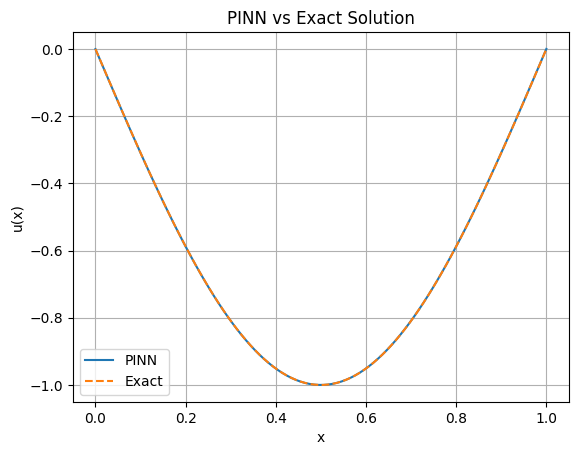

In [6]:
x_test = torch.linspace(0, 1, 100).view(-1, 1)
u_pred = model(x_test).detach().numpy()
u_exact = exact_sol(x_test.numpy())

plt.plot(x_test, u_pred, label="PINN")
plt.plot(x_test, u_exact, label="Exact", linestyle='dashed')
plt.legend()
plt.title("PINN vs Exact Solution")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.grid(True)
plt.show()


## REMARKS

### **WHAT IS `nn.Module`AND WHY IS IT FED TO THE `PINN` CLASS?**

[`nn.Module`](https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html) is a base class for all neural network modules in PyTorch. When you define your own network using a class, you subclass from `nn.Module` so you can:

* Register your layers properly
* Use `.parameters()` to collect weights for the optimizer
* Enable `.to(device)`, `.train()`, `.eval()` modes
* Easily save/load models with `torch.save()` / `load_state_dict()`

It’s like the neural network's backbone.

### **DOES ONE MUST USE A CLASS?**

No — not strictly. For quick scripts or minimal models, you can use a torch.nn.Sequential directly, like this:

```Python
model = nn.Sequential(
    nn.Linear(1, 20),
    nn.Tanh(),
    nn.Linear(20, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
)
```

This is valid and works. But it becomes hard to:

* Customize the forward pass
* Add skip connections, multiple inputs, etc.
* Compute intermediate outputs (e.g., for PINNs!)

**So, in general, using a class is better — because you often need more control over the forward computation.**


### **WHAT DOES `super(PINN,self).__init__()` DO?**

To do

```Python
class PINN(nn.Module):
    def __init__(self, ...):
        super(PINN, self).__init__()
```

You're saying:

        "Call the constructor of the nn.Module class — the parent of PINN — so it can initialize its internal stuff (e.g., tracking submodules, parameters, hooks)."

If you skip this line, PyTorch won’t register your layers correctly and weird bugs will happen. 

In other words, `super` calls the base class (`nn.Module`) constructor to initialize your model properly.


### **`torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]`**

READ: [A Gentle Introduction to torch.autograd](https://docs.pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

This part is critical for vector outputs (even if it's 1D). **Why?** Because autograd computes **vector-Jacobian products**. It needs to know what to multiply the gradient by — and you must provide the multiplier explicitly. In our case, `u` is shape `(N, 1)` — a vector. To compute $du(x)/dx$ for each point, we tell PyTorch: "Take ∂u/∂x for each element and multiply by 1." If If you leave this part it out, PyTorch will complain or return nothing.

About the `create_graph=True`:
* It's like saying: “Keep the computation graph of this derivative so I can take derivatives of the derivative later.” **This is required when you're going to do second derivatives**. **If you don’t use create_graph=True, PyTorch will treat the result as a constant and you won’t be able to differentiate it again.**

About the `[0]`:
* Because `torch.autograd.grad()` returns a tuple, even if it only returns one gradient. So we extract the first (and only) item with `[0]`.


### **WHY ADAM?**

1. Robustness during early training
    * Adam is an **adaptive optimizer**, meaning:
        * It adjusts the learning rate for each parameter individually
        * It combines the benefits of momentum (like in SGD+momentum) and RMSProp (adaptive scaling)
    * This makes it **stable and fast at the beginning**, especially when:
        * Gradients are noisy (which happens when we use autograd)
        * The loss surface is hard to optimize (e.g., in PINNs, which mix boundary loss + physics residual)

2. No need for hand-tuned learning rate schedules initially
* PINNs can be tricky — and Adam's default behavior often gives "good enough" convergence to start with.

**REMARK**: But Adam is not perfect for convergence!

Once the model gets close to the solution, Adam can plateau or oscillate. So many PINN papers and practitioners do:

```Python
# Stage 1: Fast pretraining with Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Stage 2: Precision tuning with L-BFGS (quasi-Newton)
optimizer = torch.optim.LBFGS(model.parameters(), ...)
```

So, the question turns to: **Should you always switch to L-BFGS?**

L-BFGS can often sharpen the final fit, especially when:
* Your physics loss gets stuck around 1e-3 to 1e-2
* The predicted solution still has small ripples

But L-BFGS is more sensitive, slower per step, and harder to tune. It also requires careful closure functions in PyTorch.

**REMEMBER TO READ** [Which Optimizer Works Best for Physics-Informed Neural Networks and Kolmogorov-Arnold Networks?](https://arxiv.org/abs/2501.16371) a 2025 research paper!